In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import os, time, datetime, re, pathlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from torchvision import transforms
from torchvision import utils as vutils
from IPython.display import clear_output
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Variáveis

In [20]:
NOISE_DIM = 100
BATCH_SIZE = 128
EPOCHS = 100
IMG_SIZE = 128
LEARNING_RATE = 0.0002
IMGS_DIR = './imgs/img_align_celeba'

# Criando Dataset e transformers

len(dataset)=202599
imgs_batch.shape=torch.Size([32, 3, 128, 128])


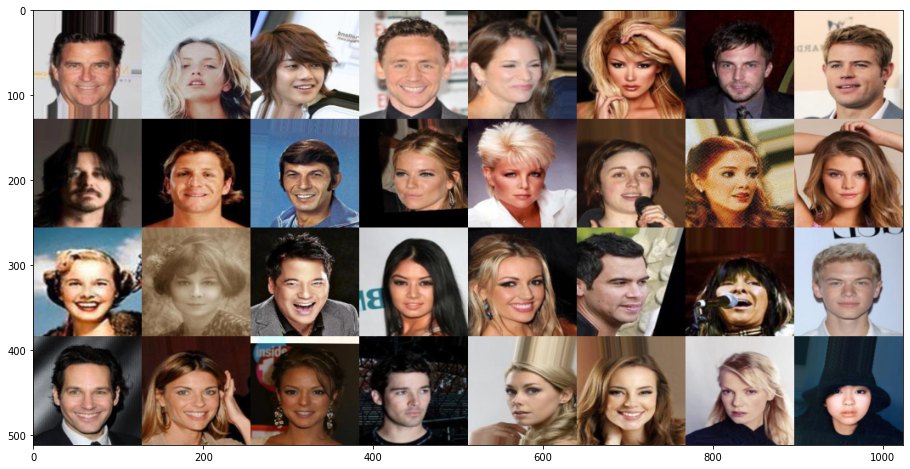

In [28]:
transformer = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1,), std=(2,)),
    transforms.ToPILImage()
])

class custom_dataset(Dataset):
    def __init__(self, imgs_path, n = None):
        imgs_list = list(pathlib.Path(imgs_path).glob('*.jpg'))
        if (n):
            imgs_list = imgs_list[:n]
        
        self.imgs_list = [str(i) for i in imgs_list]
    
    def __len__(self):
        return len(self.imgs_list)
    
    def __getitem__(self, index):
        return transformer(Image.open(self.imgs_list[index]))

dataset = custom_dataset(IMGS_DIR)
print (f'{len(dataset)=}')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
imgs_batch = next(iter(dataloader))
print (f'{imgs_batch.shape=}')
grid_tensor = vutils.make_grid(imgs_batch, nrow=8, padding=0, normalize=True)
grid_np = np.transpose(grid_tensor.detach().numpy(), (1, 2, 0))

plt.figure(figsize=(20, 8))
plt.imshow(grid_np)
plt.show() 

# Criando generator e Discriminator e get_noise

In [16]:
def get_noise(b_size_, device_ = torch.device('cpu')):
    return torch.randn((b_size_, NOISE_DIM, 1, 1), device=device_)

def create_Generator():
    return nn.Sequential(
        
        nn.ConvTranspose2d(in_channels=NOISE_DIM, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(num_features=1024),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

def create_Discriminator():
    return nn.Sequential(

        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=512),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=1024),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=1, bias=False),
        nn.Sigmoid()
    )

generator = create_Generator()
noise = get_noise(64)
print (f'{noise.shape=}')
output_generator = generator(noise)
print (f'{output_generator.shape=}')

discriminator = create_Discriminator()
output_discriminator = discriminator(output_generator)
print (f'{output_discriminator.shape=}')

noise.shape=torch.Size([64, 100, 1, 1])
output_generator.shape=torch.Size([64, 3, 128, 128])
output_discriminator.shape=torch.Size([64, 1, 1, 1])


# Funções úteis

In [41]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

FATOR = 1.0
def tensor_of_ones(b_size_, device_=torch.device('cpu')):
    return FATOR*torch.ones((b_size_,), device=device_)

def tensor_of_zeros(b_size_, device_=torch.device('cpu')):
    return (1-FATOR)*torch.ones((b_size_,), device=device_)

def listar_checkpoints():
    checkpoint_list = list(pathlib.Path('./models/').glob('*.pt'))

    aux = []
    for ch in checkpoint_list:
        epoch = int(re.findall(r'[0-9]{1,}', str(ch))[0])
        aux.append([str(ch), epoch])
    
    # ordernar por epoch mais antiga em primeiro
    aux = sorted([[ch, ep] for ch, ep in aux], key=lambda item:item[1], reverse=True)
    
    return aux

def aproveitar_modelos_treinados():

    print ('Criando modelos...')
    g = create_Generator()
    d = create_Discriminator()

    checkpoint_list = listar_checkpoints()

    if (len(checkpoint_list) > 0):
        
        last_checkpoint_path, last_epoch = checkpoint_list[0]  # mais antigo

        last_checkpoint = torch.load(last_checkpoint_path, map_location=torch.device('cpu'))

        print ('Importando last_state_dict...')
        print ('Generator: ', end='')
        print (g.load_state_dict(last_checkpoint['generator_state_dict']))
        print ('Discriminator: ', end='')
        print (d.load_state_dict(last_checkpoint['discriminator_state_dict']))

        fixed_noise_ = last_checkpoint['fixed_noise']
        results = last_checkpoint['results']
    
    else:
        print ('Não tem modelos previamente treinados. Aplicando inicialização dos pesos.')
        g.apply(weights_init)
        d.apply(weights_init)
        fixed_noise_ = get_noise(64)
        last_epoch = 0
        results = []
    
    return g, d, fixed_noise_, last_epoch, results

def salvar_checkpoint(g_model, d_model, epoch, results, fixed_noise_):
    checkpoint = {
        'generator_state_dict': g_model.state_dict(),
        'discriminator_state_dict': d_model.state_dict(),
        'results': results,
        'epoch': epoch,
        'cabecalho': ['epoch', 'd_real_loss', 'g_fake_loss', 'g_loss', 'time'],
        'datetime': datetime.datetime.now().strftime('%d/%m/%Y, %H:%M'),
        'fixed_noise': fixed_noise_
    }
    torch.save(checkpoint, f'./models/checkpoint_{epoch}.pt')

def deletar_modelos_antigos():
    checkpoints_list = listar_checkpoints()
    if (len(checkpoints_list) > 0):
        for checkpoint_path, _ in checkpoints_list[2:]: # deixando somente os dois últimos treinados.
            try:
                os.remove(checkpoint_path)
            except:
                pass

def criar_imagem(fixed_noise_, epoch):
    with torch.no_grad():
        images = generator(fixed_noise_)
        grid_tensor = vutils.make_grid(images, nrow=8, padding=0, normalize=True)
        grid_np = np.transpose(grid_tensor.detach().cpu().numpy(), (1, 2, 0))
        img_np = np.array(grid_np*255, dtype=np.uint8)
        img_pil = Image.fromarray(img_np)
        img_pil.save(f'./imgs_results/img_{epoch}.jpg')

def criar_pastas():
    for dir_path in ['imgs_results', 'models']:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        else:
            print (f'{dir_path} já existia')

criar_pastas()

def create_image_from_fixed_noise(fixed_noise_, epoch_, model_g):
    
    with torch.no_grad():
        images_tensor = model_g(fixed_noise_)
    
    grid_tensor = vutils.make_grid(images_tensor, nrow=8, padding=0, normalize=True)
    grid_np = np.transpose(grid_tensor.detach().cpu().numpy(), (1, 2, 0))
    image_pil = Image.fromarray(np.uint8(grid_np*255))
    image_pil.save(f'./imgs_results/img_{str(epoch_).zfill(4)}_epoch.jpg')
    
    
def analisar_dados_epoca(results_, model_g, device_=torch.device('cpu')):
    results_ = np.array(results_)
    noise = get_noise(4, device_ = device_)
    with torch.no_grad():
        fake_ = model_g(noise)
    
    grid_tensor = vutils.make_grid(fake_, nrow=4, padding=0, normalize=True)
    grid_np = np.transpose(grid_tensor.detach().cpu().numpy(), (1, 2, 0))
    
    plt.figure(figsize=(20, 8))

    for k, label in enumerate(['d_real_loss', 'd_fake_loss', 'g_loss', 'time']):
        plt.subplot(3, 2, k+1)
        plt.plot(results_[:,k+1], label=label)
        plt.legend()

    img_pil = Image.new('RGB', size=(150, 110), color='white')
    draw = ImageDraw.Draw(img_pil)
    fonte = ImageFont.load_default()
    draw.text((10, 10), f'Épocas: {len(results_)}/{EPOCHS}', font=fonte, fill=0)
    draw.text((10, 30), f'Tempo total: {round(results_[:,-1].sum())} seg', font=fonte, fill=0)
    draw.text((10, 50), f'Device: {device}', font=fonte, fill=0)
    draw.text((10, 70), f'NOISE_DIM: {NOISE_DIM}', font=fonte, fill=0)
    draw.text((10, 90), f'BATCH_SIZE: {BATCH_SIZE}', font=fonte, fill=0)
    plt.subplot(3, 2, 5)
    plt.imshow(img_pil)

    plt.subplot(3, 2, 6)
    plt.imshow(grid_np)
    plt.show()

print (tensor_of_ones(5))
print (tensor_of_zeros(5))

imgs_results já existia
models já existia
tensor([1., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0.])


# Preparativos para treinamento

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'{device=}')

dataset = custom_dataset(IMGS_DIR, 200)
print (f'{len(dataset)=}')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
len_dataloader = len(dataloader)
print (f'{len_dataloader=}')

generator, discriminator, fixed_noise, last_epoch, results = aproveitar_modelos_treinados()
print (f'{last_epoch=}')
print (f'{EPOCHS=}')

generator.to(device)
discriminator.to(device)
fixed_noise = fixed_noise.to(device)
print (f'{fixed_noise.shape=}')

criterion = nn.BCELoss()
print (f'{criterion=}')
criterion.to(device)

print ('Criando otimizadores..')
optim_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(.5, .999))
optim_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(.5, .999))
print (f'{optim_discriminator=}')
print (f'{optim_generator=}')

device=device(type='cpu')
len(dataset)=200
len_dataloader=2
Criando modelos...
Não tem modelos previamente treinados. Aplicando inicialização dos pesos.
last_epoch=0
EPOCHS=100
fixed_noise.shape=torch.Size([64, 100, 1, 1])
criterion=BCELoss()
Criando otimizadores..
optim_discriminator=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)
optim_generator=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)


# Treinamento

In [ ]:
generator.train()
discriminator.train()
print ('iniciando treinamento...')

while (last_epoch < EPOCHS):
    inicio = time.time()
    v_real_loss, v_fake_loss, v_g_loss = [], [], []
    with torch.set_grad_enabled(True):
        for real_imgs in tqdm(dataloader):
            
            real_imgs = real_imgs.to(device)
            b_size = len(real_imgs)

            # Treinando o discriminator
            discriminator.zero_grad()
            output_real = discriminator(real_imgs)
            loss_real = criterion(output_real.view(-1), tensor_of_ones(b_size, device))
            loss_real.backward()

            noise = get_noise(b_size, device_=device)
            fake_imgs = generator(noise)
            output_fake = discriminator(fake_imgs.detach())
            loss_fake = criterion(output_fake.view(-1), tensor_of_zeros(b_size, device))
            loss_fake.backward()

            optim_discriminator.step()

            v_real_loss.append(loss_real.item())
            v_fake_loss.append(loss_fake.item())

            # Treinando o generator
            generator.zero_grad()
            output_for_generator = discriminator(fake_imgs)
            loss_for_generator = criterion(output_for_generator.view(-1), tensor_of_ones(b_size, device))
            loss_for_generator.backward()
            optim_generator.step()

            v_g_loss.append(loss_for_generator.item())

    v_real_loss = np.array(v_real_loss).mean()
    v_fake_loss = np.array(v_fake_loss).mean()
    v_g_loss = np.array(v_g_loss).mean()
    last_epoch += 1
    tempo = time.time() - inicio

    vetor = [last_epoch, v_real_loss, v_fake_loss, v_g_loss, tempo]
    results.append(vetor)
    
    salvar_checkpoint(generator, discriminator, last_epoch, results, fixed_noise)
    deletar_modelos_antigos()
    clear_output(wait=True)
    analisar_dados_epoca(results_=results, model_g=generator, device_=device)
    create_image_from_fixed_noise(fixed_noise, last_epoch, generator)